# Example Pipeline for Simulated Data

This notebook is a proof-of-concept for generating causal samples from external samples

In [4]:
!ls ../data/analysis

__pycache__                   data.csv
credence-to-causal-estimation experimenting_with_R.R


In [1]:
import sys
sys.path.append("../")  # go to parent dir
sys.path.append("../data/analysis/")  # go to parent dir

import jax
import jax.random as jr
import jax.numpy as jnp
# jnp.set_printoptions(precision=2)
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import rankdata

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage

from frugal_flows.causal_flows import independent_continuous_marginal_flow, get_independent_quantiles, train_frugal_flow
from frugal_flows.sample_outcome import sample_outcome
from frugal_flows.sample_marginals import from_quantiles_to_marginal_cont, from_quantiles_to_marginal_discr
from frugal_flows.train_quantile_propensity_score import train_quantile_propensity_score
from frugal_flows.bijections import UnivariateNormalCDF

import data.template_causl_simulations as causl_py
import wandb

# Activate automatic conversion of rpy2 objects to pandas objects
pandas2ri.activate()
base = importr('base')
utils = importr('utils')

# Import the R library causl
try:
    causl = importr('causl')
except Exception as e:
    package_names = ('causl')
    utils.install_packages(StrVector(package_names))

hyperparam_dict = {
    "RQS_knots": 8,
    "nn_depth": 4,
    "nn_width": 50,
    "flow_layers": 4,
    "learning_rate": 5e-3,
    "max_epochs": 1000,
    "max_patience": 100,
}

seed = 0
N = 5000
sampling_size = 1000
causal_params = [0, 1]
keys, *subkeys = jr.split(jr.PRNGKey(seed), 20)

In [2]:
from validationMethods import *

ModuleNotFoundError: No module named 'validationMethods'

In [2]:
def bivariate_gaussian_copula(key, N, rho):
    corr_matrix = jnp.array([
        [1., rho],
        [rho, 1.]
    ])
    mean = jnp.array([0,0])
    quantiles = jax.scipy.special.ndtr(
        jr.multivariate_normal(key=key, mean=mean, cov=corr_matrix, shape=(N,))
    )
    return quantiles[:, 0], quantiles[:, 1]

In [3]:
Z_disc, Z_cont, X, Y = causl_py.generate_discrete_samples(N=N, seed=0, causal_params=causal_params).values()

In [4]:
res = get_independent_quantiles(
    key=subkeys[0],
    z_cont=Z_cont,
    z_discr=Z_disc,
    max_epochs=1000,
    max_patience=100,
    return_z_cont_flow=True
)
uz_full_samples = jnp.hstack([res['u_z_cont'], res['u_z_discr']])

 30%|█████████████████████████████▉                                                                       | 297/1000 [00:30<01:11,  9.81it/s, train=1.75660020196647, val=1.7507433308944922 (Max patience reached)]


In [5]:
jnp.cov(jax.scipy.special.ndtri(res['u_z_cont']).T)

Array([[0.97760908, 0.35886636],
       [0.35886636, 1.00429202]], dtype=float64)

In [6]:
fitted_flow, losses = train_frugal_flow(
    key=subkeys[1],
    y=Y,
    u_z=uz_full_samples,
    condition=X,
    causal_model="location_translation",
    causal_model_args={'ate': 0., **hyperparam_dict},
    **hyperparam_dict
)
causal_margin = fitted_flow.bijection.bijections[-1].bijections[0]

 12%|███████████▌                                                                                       | 117/1000 [00:50<06:23,  2.30it/s, train=0.9929109406817149, val=1.4106291427939166 (Max patience reached)]


In [7]:
print(causal_margin.ate)

0.9850151457041446


## How we can find $U_z$ samples from a fitted copula whilst controlling the $U_{y\mid x}$ samples

1. Sample $U^{*}_{Y\mid X}$
1. Sample $U_{Z}$ baselines
1. Sample from frugal flow to get $U_{Z}$
1. Get $Z$ samples
1. Train Propensity Flow
1. Get $X$ from $Z$ and $U_{X\mid Z}$
1. Sample $Y$ from $U^{*}_{Y\mid X}$

1. Sample $U_{Y\mid X}$ and $U_{X\mid Z}$

In [13]:
rho = 0.5
u_yx, u_xz = bivariate_gaussian_copula(jr.PRNGKey(123), sampling_size, rho)
u_yx = u_yx[:, None]
u_xz = u_xz[:, None]

2. Sample $U_{Z}$ baselines

In [14]:
baseline_uz = jr.uniform(key=subkeys[4], shape=(sampling_size, 4))

3. Sample from Frugal Flow to get $U_{Z}$

In [16]:
frugal_baselines = jnp.hstack([u_yx, baseline_uz])
vmap_frugal_flow = jax.vmap(fun=fitted_flow.bijection.transform, in_axes=(0))
Y_samples = vmap_frugal_flow(x=frugal_baselines, condition=jnp.zeros(u_yx.shape))[:, 0]
uz_samples = vmap_frugal_flow(x=frugal_baselines, condition=jnp.zeros(u_yx.shape))[:, 1:]

4. Get $Z$ samples

In [17]:
Z_cont_samples = from_quantiles_to_marginal_cont(
    key=subkeys[5],
    flow=res['z_cont_flows'],
    n_samples=sampling_size,
    u_z=uz_samples[:, :2]
)

In [18]:
Z_disc_samples = from_quantiles_to_marginal_discr(
    key=subkeys[6],
    mappings=res['z_discr_rank_mapping'],
    empirical_cdfs=res['z_discr_empirical_cdf_long'],
    nvars=res['u_z_discr'].shape[1],
    n_samples=sampling_size,
    u_z=uz_samples[:, 2:]
)

In [19]:
full_Z_samples = jnp.hstack([Z_cont_samples, Z_disc_samples])

5. Train Propensity Flow

In [20]:
prop_flow, losses = train_quantile_propensity_score(
    key=subkeys[2],
    x=X.astype(int),
    condition=jnp.hstack([Z_disc, Z_cont])
)

 20%|███████████████████▌                                                                              | 20/100 [00:03<00:14,  5.46it/s, train=-0.37353490914253895, val=-0.3123344570022014 (Max patience reached)]


6. Sample $X$ from $U_{X\mid Z}$

In [21]:
prop_flow_cdf = prop_flow.bijection.transform
vmapped_prop_flow_cdf = jax.vmap(prop_flow_cdf, in_axes=(0,))
u_x = vmapped_prop_flow_cdf(u_xz, condition=full_Z_samples)

In [22]:
X_samples = (u_x > (1 - jnp.mean(X))).astype(int)

7. Sample Y from $U^{*}_{Y\mid X}

/Users/danielmanela/Library/CloudStorage/GoogleDrive-danielmanela@gmail.com/My Drive/work/deep-copula-frugal/validation/../frugal_flows/sample_outcome.py:60: UserWarning: Since both frugal flow object and u_yx are provided to location_translation model, u_yx quantiles will be used to sample from the flow object. If you want to fully sample from the flow object, please provide only the frugal flow object.
  warnings.warn(


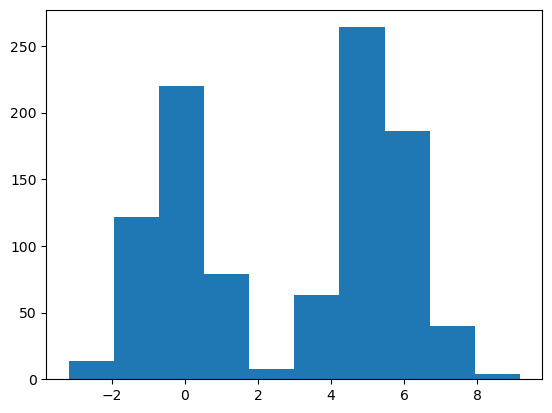

In [24]:
Y_samples = sample_outcome(
    frugal_flow=fitted_flow,
    key=jr.PRNGKey(10),
    n_samples=sampling_size,
    causal_model='location_translation',
    causal_condition=X_samples[:, None],
    u_yx=u_yx.flatten(),
    **{'ate': 5}
)
plt.hist(Y_samples.T);

## Concatenate full data together

In [25]:
sim_data = jnp.hstack([Y_samples, X_samples, full_Z_samples])
sim_data_df = pd.DataFrame(sim_data, columns=['Y', 'X', *[f"Z_{i+1}" for i in range(full_Z_samples.shape[1])]])

In [26]:
sim_data_df

,Y,X,Z_1,Z_2,Z_3,Z_4
0,6.952709,1.0,2.084566,1.292546,1.0,1.0
1,4.293337,1.0,-1.117203,-0.881514,1.0,1.0
2,4.632083,1.0,0.917662,0.966352,0.0,1.0
3,-0.596116,0.0,0.009526,-0.694892,1.0,0.0
4,5.962860,1.0,1.007556,0.890902,1.0,1.0
...,...,...,...,...,...,...
995,6.458470,1.0,1.068450,-0.651313,0.0,1.0
996,5.284184,1.0,-0.166962,1.325831,1.0,1.0
997,0.596289,0.0,0.772433,-1.160791,1.0,1.0
998,4.343938,1.0,-0.014590,0.011042,1.0,1.0
